# Making maps

![All the suburbs in Sydney](all_burbs.png)

We're going to get some shapefiles from data.gov.au, and then we're going to draw some maps

---

You'll need some prequisite libraries.

If you're on a mac, it's easy, just do this:
```
pip install pandas shapely fiona descartes pyproj 
pip install geopandas
```
You may have some already but pip will be cool with that.

If you are on windows, geopandas is installed differently, so follow these 3 steps:

1. Install Visual CPPD Build Tools with the following link: https://visualstudio.microsoft.com/visual-cpp-build-tools/
2. Restart your computer
3. Open Visual Studio Code again after the restart and copy and paste the following commands into your terminal:

    ```
    pip install wheel
    pip install pipwin
    pip install numpy
    pip install pandas
    pip install shapely
    pip install pyproj
    pip install six
    pip install rtree
    pipwin install gdal
    pipwin install fiona
    pip install descartes
    pip install geopandas
    ```

Copy that whole lot into your terminal, press enter, and it'll sort it out.

We're going to get a shapefile of suburb boundaries from here:

https://data.gov.au/dataset/ds-dga-91e70237-d9d1-4719-a82f-e71b811154c6/details

In [24]:
import os
import geopandas as gp
import shapely
import fiona
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


shp_file_name = "NSW_LOCALITY_POLYGON_shp/NSW_LOCALITY_POLYGON_shp.shp"
zip_file_name = "nsw_locality_polygon_shp.zip"
web_file_path = (
    "https://data.gov.au/data/dataset/"
    "91e70237-d9d1-4719-a82f-e71b811154c6/resource/"
    "5e295412-357c-49a2-98d5-6caf099c2339/download/"
    "nsw_locality_polygon_shp.zip"
)


In [25]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

To get a load of shape files from data.gov.au, more specifically, [here](https://data.gov.au/dataset/nsw-suburb-locality-boundaries-psma-administrative-boundaries/resource/bf8b5180-fcea-44bd-bd76-af14cc4b0fe0)

In [26]:
def unzip_zipfile(zipped_file_path, put_it_here="."):
    import zipfile
    zip_of_suburbs = zipfile.ZipFile(zipped_file_path, 'r')
    zip_of_suburbs.extractall(put_it_here)
    zip_of_suburbs.close()

In [27]:
# Get the data loaded. This is a bit complicated because it's online as a zip file.
# If we don't have it right now, we need to get it and unzip it.
if os.path.isfile(shp_file_name):
    print("loading from file")
else:
    if os.path.isfile(zip_file_name):
        print("unzipping")
        unzip_zipfile(zip_file_name)
    else:
        import requests
        print("loading from the internet")
        page = requests.get(web_file_path)
        with open(zip_file_name, 'wb') as z:
            z.write(page.content)
        unzip_zipfile(zip_file_name)

print("done")

loading from file
done


#### Shapefiles are the format that a lot of GIS tools use.

#### GIS means Geographic Information System

pronounced: _gee eye ess_

not pronounced: _jizz_

In [28]:
burbs = gp.GeoDataFrame.from_file(shp_file_name)
burbs.set_crs(epsg=5234, inplace=True, allow_override=True) 
# https://epsg.io/8021
# GDA2020 is the latest and least wrong coord set for Sydney
burbs.sample(2)

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,NSW_LOCALI,NSW_LOCA_1,NSW_LOCA_2,NSW_LOCA_3,NSW_LOCA_4,NSW_LOCA_5,NSW_LOCA_6,NSW_LOCA_7,geometry
450,21986,2013-11-25,None,NSW3248,2014-02-01,None,PINNACLE SWAMP,None,None,G,None,1,"POLYGON ((149.91755 -32.73986, 149.91789 -32.7..."
1272,28598,2018-06-07,None,NSW479,2018-08-08,None,BONVILLE,None,None,G,None,1,"POLYGON ((153.03080 -30.33352, 153.02979 -30.3..."


There are a bunch of junk columns in there. Normally I'd leave them in, but because we're going to be looking are this data in dataframes, I'll take them out so that it's easier on the eyes.

In [29]:
cols_to_drop = ["NSW_LOCA_1", "NSW_LOCA_3", "NSW_LOCA_4","NSW_LOCA_5","NSW_LOCA_7", "DT_RETIRE"]
burbs.drop(cols_to_drop, axis=1, inplace=True, errors="ignore")
burbs.head(2)

,LC_PLY_PID,DT_CREATE,LOC_PID,NSW_LOCALI,NSW_LOCA_2,NSW_LOCA_6,geometry
0,25065,2015-09-03,NSW2557,2015-11-10,MAYFIELD WEST,None,"POLYGON ((151.73345 -32.87974, 151.73286 -32.8..."
1,16193,2011-11-22,NSW4136,2012-02-04,WALLACETOWN,None,"POLYGON ((147.45092 -34.96519, 147.45639 -34.9..."


Only uncomment this if you've got a fast computer and a lot of time!

It makes the map at the top of this file.

In [30]:
# burbs.geometry.plot()

Let's pull out a single row, a single suburb, and look at it.

LC_PLY_PID                                                25065
DT_CREATE                                            2015-09-03
LOC_PID                                                 NSW2557
NSW_LOCALI                                           2015-11-10
NSW_LOCA_2                                        MAYFIELD WEST
NSW_LOCA_6                                                 None
geometry      POLYGON ((151.73344571654 -32.87974104891, 151...
Name: 0, dtype: object


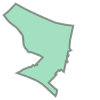

In [31]:
a = burbs.iloc[0]
print(a)
a.geometry

When we plot a geopandas polygon\* it actually draws it, rather than showing the textual information, which is nice.

\* it's acutally a Shapely polygon I think.

---

If we want to measure some distances, we need _points_. The distance between two shapes is ambiguous.

The easiest way to do this is to get the centroid of the polygon.

In [32]:
def add_centroid(row):
    return row.geometry.centroid

burbs["centroid"] = burbs.apply(add_centroid, axis=1)

burbs.sample(2)

,LC_PLY_PID,DT_CREATE,LOC_PID,NSW_LOCALI,NSW_LOCA_2,NSW_LOCA_6,geometry,centroid
1824,28627,2018-06-07,NSW3249,2018-08-08,PINNY BEACH,None,"POLYGON ((151.63633 -33.09898, 151.63655 -33.0...",POINT (151.6356541093876 -33.11801816446822)
327,20462,2013-03-07,NSW968,2013-04-30,COBRAMUNGA,None,"POLYGON ((143.88359 -35.38336, 143.88536 -35.3...",POINT (143.8871706757373 -35.4413524087653)


And we can plot this nicely as a map. Note that this is different to doing a `scatter` of lat and long because it's aware that they're spatially related; no squishing.

<AxesSubplot:>

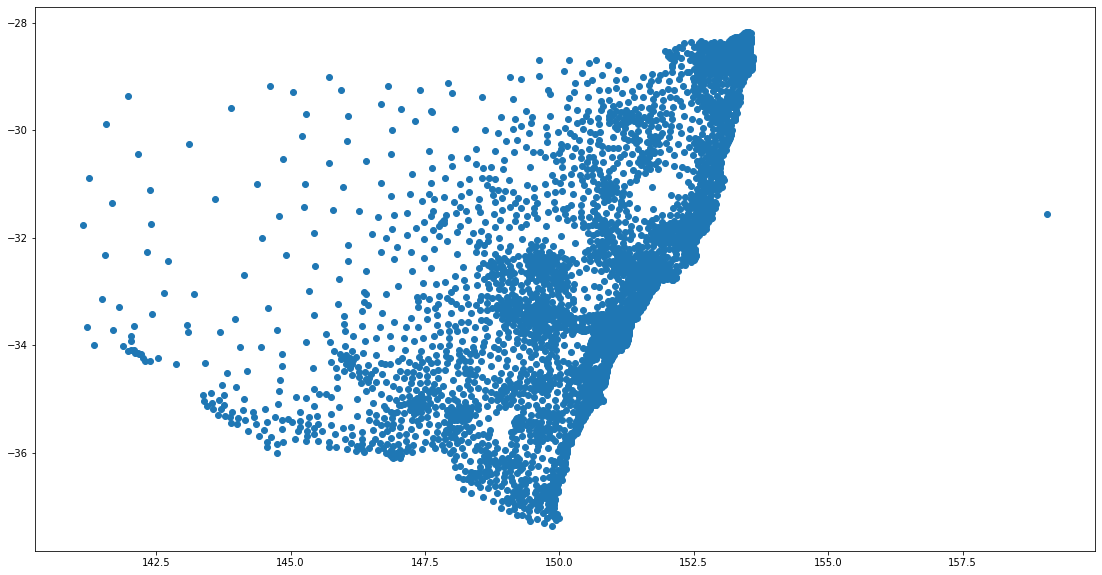

In [33]:
burbs.centroid.plot()

POINT (151.7246099649729 -32.88497041458911)


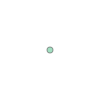

In [34]:
a = burbs.iloc[0]
print(a.centroid)
a.centroid

Let's make a new point that's on the UNSW campus. We need to use shapely to do this.

Then calculate the distance from that point to the centroid of each suburb.

In [35]:
right_here = shapely.geometry.point.Point(151.2299732, -33.9178754)
burbs["distance_from_UNSW"] = burbs.centroid.distance(right_here)

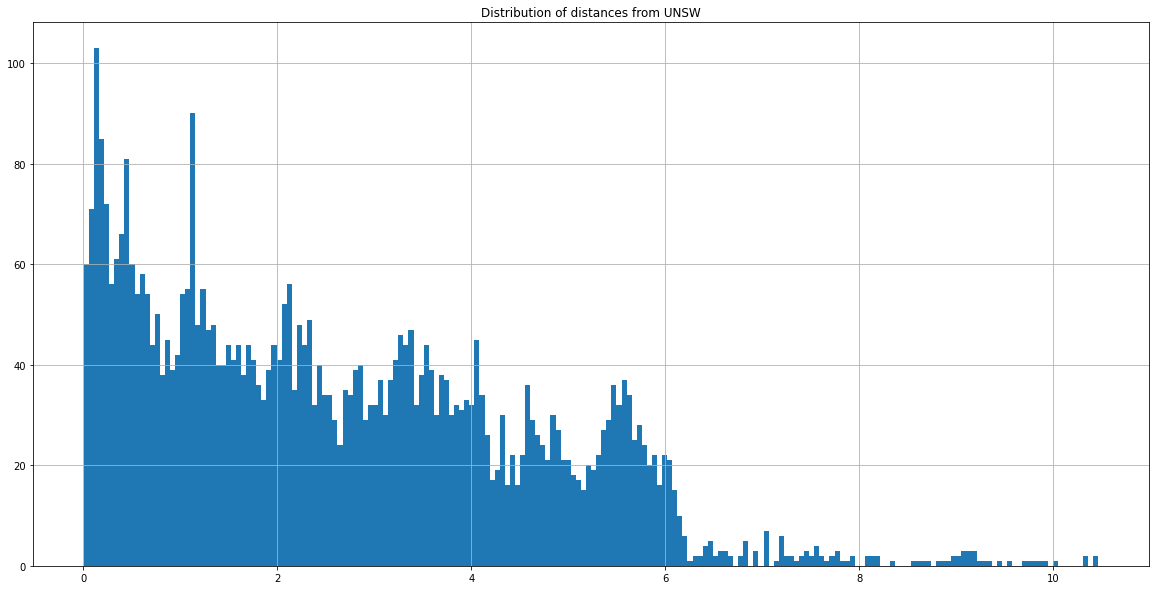

In [36]:
burbs.distance_from_UNSW.hist(bins=200)
plt.title("Distribution of distances from UNSW");

This gives distance in whole numbers of lat long I think, i.e. degrees!

Not really sure what to do with that, but let's get rid of everything above 0.2 and see what we can plot:

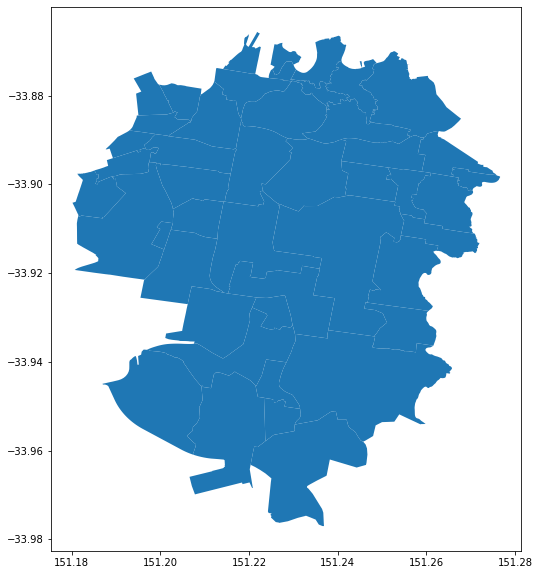

In [37]:
close_burbs = burbs[burbs.distance_from_UNSW < 0.05]
close_burbs.plot();

We can simplify shapes in a few ways:

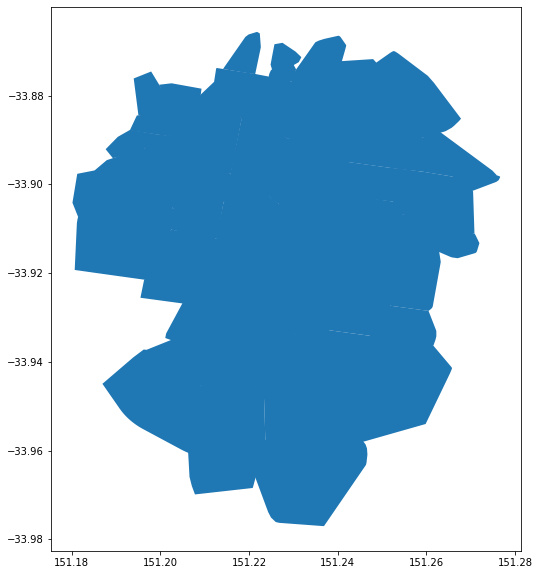

In [38]:
close_burbs.geometry.convex_hull.plot();

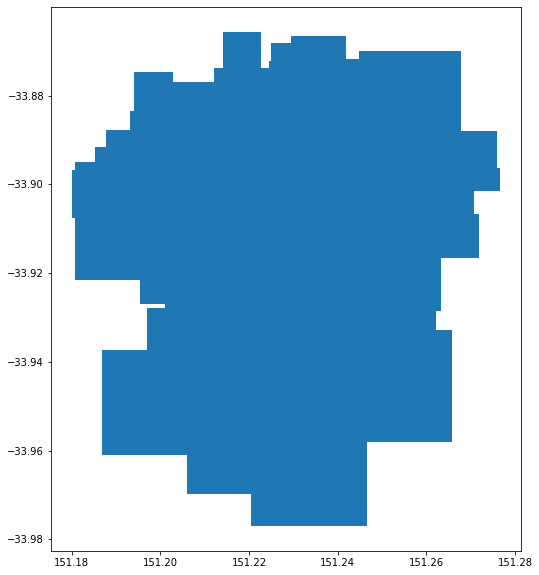

In [39]:
close_burbs.geometry.envelope.plot();

![](http://www.personal.kent.edu/~rmuhamma/Compgeometry/MyCG/Gifs-CompGeometry/ch2.gif)

Convex hulls are a useful aproximation if you want to do fast calculations.

You can use this to speed up calculations sometimes. It goes radius, bounding box, convex hull, complex polygon. I.e. if the points are not within radius_1 + radius_2 of each other, there's no point doing any other checks.

Often it's faster to do all of these checks in order, flowing from one to the next, than it is to just go straight to the most complex. But that depends on how much effort you can be bothered to put in.

What about putting labels on the map?

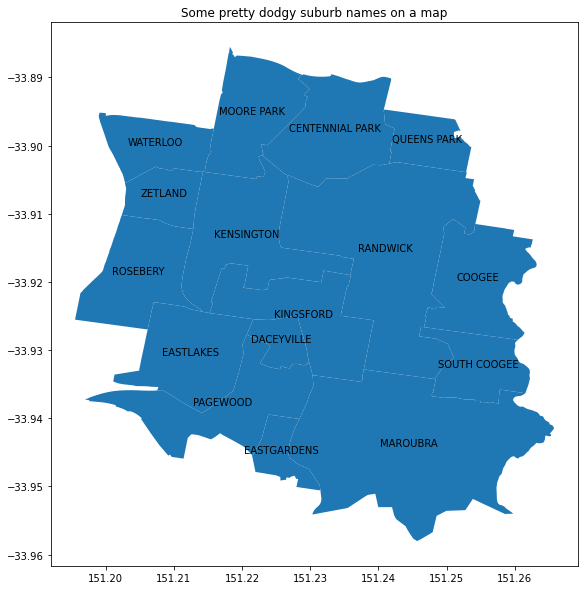

In [47]:
really_close_burbs = burbs[burbs.distance_from_UNSW < 0.03]
really_close_burbs.plot()

for idx, row in really_close_burbs.iterrows():
#     print(idx, row)
#     print("annotation", row.NSW_LOCA_2)
#     print("coords", row.centroid.coords, 
#           "tup", tuple(row.centroid.coords), 
#           "zero", tuple(row.centroid.coords)[0])
    plt.annotate(text=row.NSW_LOCA_2, 
                 xy=tuple(row.centroid.coords)[0],
                 xycoords="data",
                 horizontalalignment='center')
plt.title("Some pretty dodgy suburb names on a map");

We often want to be able to tell if a point is in a suburb or not. We'd do that with a polygon inclusion test.

![](http://www.geeksforgeeks.org/wp-content/uploads/polygon31.png)

[How to check if a given point lies inside or outside a polygon?](http://www.geeksforgeeks.org/how-to-check-if-a-given-point-lies-inside-a-polygon/)

Luckily we've got one built in!

In [41]:
print(right_here)
in_this_burb = None
for _, row in really_close_burbs.iterrows():
    if right_here.within(row.geometry):
        in_this_burb = row
        
in_this_burb

POINT (151.2299732 -33.9178754)


LC_PLY_PID                                                        16612
DT_CREATE                                                    2012-02-16
LOC_PID                                                         NSW2123
NSW_LOCALI                                                   2012-05-04
NSW_LOCA_2                                                   KENSINGTON
NSW_LOCA_6                                                         None
geometry              POLYGON ((151.226736204561 -33.904512307867, 1...
centroid                   POINT (151.2206407346472 -33.91336830521539)
distance_from_UNSW                                             0.010364
Name: 1312, dtype: object

This might actually be a case where a `lambda` is a good idea:

In [42]:
in_this_burb = really_close_burbs[really_close_burbs.geometry.apply(lambda x: right_here.within(x))]
in_this_burb

,LC_PLY_PID,DT_CREATE,LOC_PID,NSW_LOCALI,NSW_LOCA_2,NSW_LOCA_6,geometry,centroid,distance_from_UNSW
1312,16612,2012-02-16,NSW2123,2012-05-04,KENSINGTON,None,"POLYGON ((151.22674 -33.90451, 151.22665 -33.9...",POINT (151.2206407346472 -33.91336830521539),0.010364


This is useful if you need to get the suburb name of some points. You'd check each point to see if it's in each suburb, and if it is, you've got it. Careful though, that's a O(n²) job.

How about colouring suburbs according to some kind of scalar value?

[That's called a _chloropleth_](http://geopandas.readthedocs.io/en/latest/mapping.html?highlight=color#chloropleth-maps)

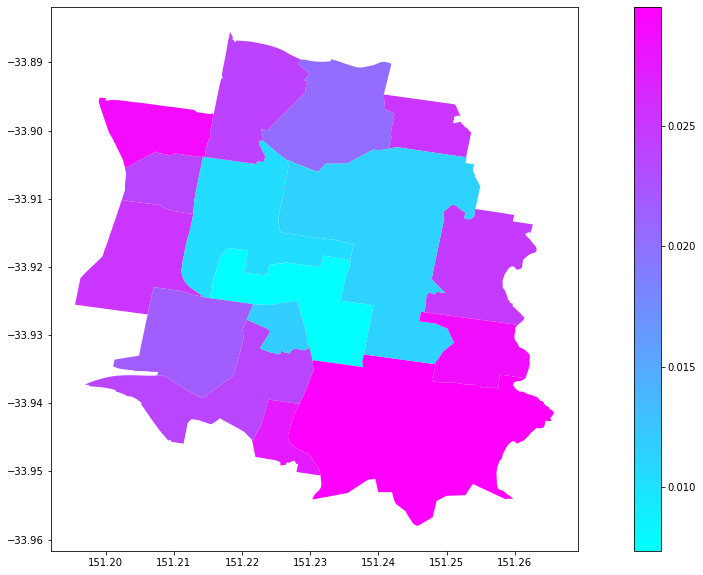

In [43]:
really_close_burbs.plot(column='distance_from_UNSW', cmap='cool', legend=True);

I don't think that could be any easier!

You can see the list of [colour scale options here](http://matplotlib.org/users/colormaps.html)

What if you want to put some points onto the map? In this case we'll plot the centroids, but you can plot any points because they are using geographic coordinates.

<AxesSubplot:>

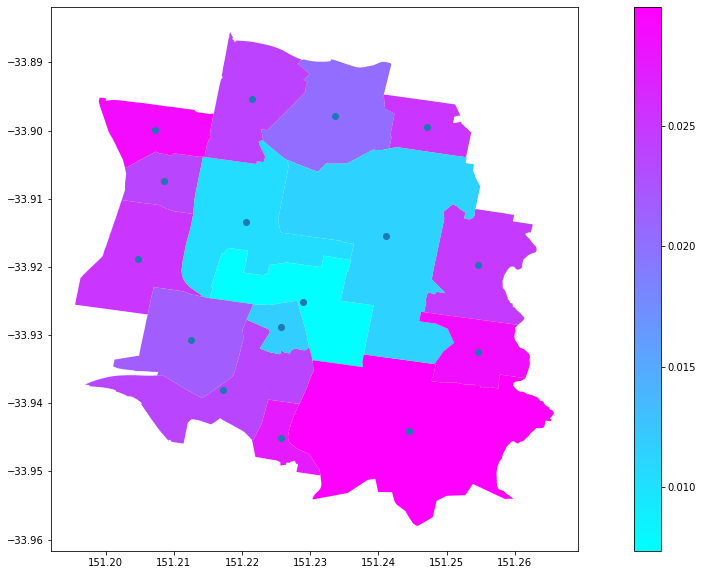

In [45]:
ax = really_close_burbs.plot(column='distance_from_UNSW', cmap='cool', legend=True)
really_close_burbs.centroid.plot(ax=ax)

## Handy links

* [Geopandas docs](http://geopandas.readthedocs.io)
* [Geopandas on GitHib](https://github.com/geopandas/geopandas)
* [Another map making tutorial](http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html)
* [MatPlotLib colour scale options](http://matplotlib.org/users/colormaps.html)

I'd love to hear if you come across any other useful things!